<a href="https://colab.research.google.com/github/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo10_l1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\ell_1$ and $\ell_p$ regression

1. Part 1: Motivation for $\ell_1$ regression
2. Part 2: Sketching approaches

For $\ell_1$ sketching, see ["The Fast Cauchy Transform..."](http://epubs.siam.org/doi/10.1137/140963698) by Clarkson et al. 2016
in SIAM J Sci Comp, and see also David Woodruff's 2014 monograph

We won't discuss $\ell_p$ in general much, but the idea for other $p$ is to find a $p$-stable distribution.  (And if I recall, the results get worse as $p\to\infty$).

Demo by Stephen Becker, 2019 and 2021

In [2]:
import numpy as np
import numpy.linalg
from numpy.random import default_rng
rng = default_rng()
import scipy.linalg
from matplotlib import pyplot as plt

## Motivation: robust regression

Let's do a regression problem, and to keep it very simple, we'll do a problem with a 1D polynomial (and in fact, we'll force it to have a 0 intercept).

We have a small amount of noise, so we start with **ordinary least squares (OLS)**
$$\min_x \|Ax-b\|_2$$

But suppose one of the entries of $b$ has a **huge** error (it's an *outlier*). Is our OLS estimate reasonable?

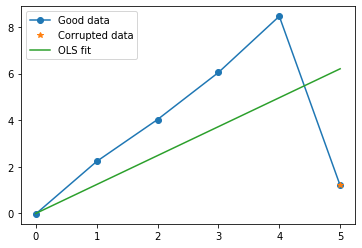

In [29]:
x   = np.array([[2]])
A   = np.arange(6).reshape( (-1,1) )
M, N = A.shape # N = 1 since 1D example
# add a small amount of noise
z   = 0.3*rng.standard_normal( (M,1) )
b   = A@x + z

b[-1] = 1.2 # gross corruption, e.g., someone typed "1.2" instead of "12"

plt.plot( A, b, 'o-',label='Good data')
plt.plot( A[-1], b[-1], '*',label='Corrupted data')

xLS   = scipy.linalg.lstsq(A,b)[0]
plt.plot( A, A@xLS, '-',label='OLS fit')

plt.legend()
plt.show()

No! Our OLS estimate is thrown off by the outlier.

Now let's try $\ell_1$ regression
$$\min_x \|Ax-b\|_1$$

This doesn't have a closed-form solution, but it is a [linear program](https://en.wikipedia.org/wiki/Linear_program), so we can efficiently solve it with optimization solvers.  We'll use the very nice [cvxpy](https://www.cvxpy.org/) package, which is an interface to several high-quality solvers.

First, as a sanity check, let's use `cvxpy` to solve the $\ell_2$ regression problem, just to make sure it matches the solution we got via linear algebra:

In [37]:
import cvxpy as cvx

beta = cvx.Variable(1)

# CVXPY's norm behaves like np.linalg.norm
obj = cvx.Minimize(cvx.norm(A*beta-b.ravel() ))
prob = cvx.Problem(obj)
prob.solve()

x_l2 = beta.value

print(x_l2[0], xLS[0][0])

1.241597331379835 1.241597333499337


Now let's move on to $\ell_1$ regression using `cvxpy`:

In [38]:
beta = cvx.Variable(1)

obj = cvx.Minimize(cvx.norm(A*beta-b.ravel(), 1 ))
prob = cvx.Problem(obj)
prob.solve()

x_l1 = beta.value

print(x_l1[0], xLS[0][0])


2.0161437331896437 1.241597333499337


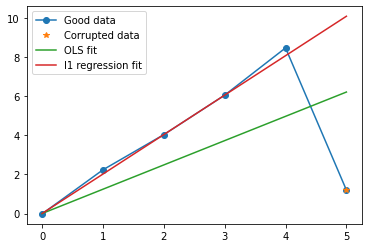

In [39]:
plt.plot( A, b, 'o-',label='Good data')
plt.plot( A[-1], b[-1], '*',label='Corrupted data')

xLS   = scipy.linalg.lstsq(A,b)[0]
plt.plot( A, A@xLS, '-',label='OLS fit')
plt.plot( A, A@x_l1, '-',label='l1 regression fit')

plt.legend()
plt.show()

It's much less sensitive to the outlier!  Exactly as we had hoped.

## Does JL apply to $\ell_p$ ($p\neq 2$) norms?

So now that we've motivated why we might want to solve $\ell_1$ regression, we ask if we can use sketching techniques to help solve it faster.  The first question is whether linear sketches can preserve $\ell_1$ norms.  We'll start with a Gaussian (or FJLT) sketch.

In [25]:
# Download sketching code
!wget -q https://raw.githubusercontent.com/stephenbeckr/randomized-algorithm-class/master/Code/sketch.py
import sketch as sk
import scipy.sparse

M, N = int(3e4), int(3e2)

X   = rng.standard_normal( (M,N) )@np.diag(np.logspace(0,4,N))@(
    rng.standard_normal((N,N) ) + 0.03*np.eye(N) )
Z   = scipy.sparse.random(M, N, density=0.01)
X   = np.hstack( (X,Z.toarray() ) )
M, N = X.shape


col2Norms = scipy.linalg.norm( X, ord=2, axis=0)
col1Norms = scipy.linalg.norm( X, ord=1, axis=0)

m   = int(3e2)
# S   = sk.FJLT( (m,M) )
S   = sk.Gaussian( (m,M) )
SX  = S@X

col2Norms_sk = scipy.linalg.norm( SX, ord=2, axis=0)
col1Norms_sk = scipy.linalg.norm( SX, ord=1, axis=0)

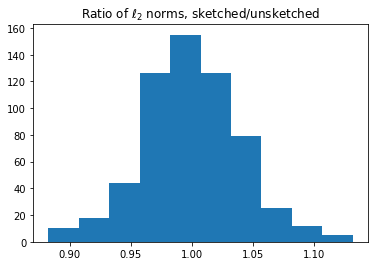

In [26]:
plt.hist( col2Norms_sk / col2Norms )
plt.title('Ratio of $\ell_2$ norms, sketched/unsketched [Gaussian sketch]')
plt.show()

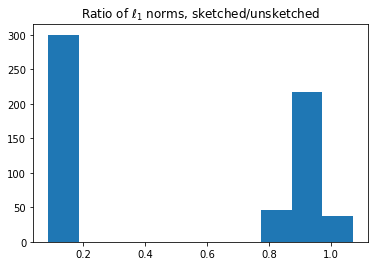

In [27]:
plt.hist( col1Norms_sk / col1Norms )
plt.title('Ratio of $\ell_1$ norms, sketched/unsketched [Gaussian sketch]')
plt.show()

As expected, the Gaussian/FJLT sketch *does* preserve $\ell_2$ norms.  It *can* preserve $\ell_1$ norms if you have a nice homogeneous dataset, but it doesn't have to preserve $\ell_1$ norms. In this example, some of the data are dense, and some are sparse, and we see very different behaviors for the two classes of data.

We conclude that the Gaussian/FJLT sketch does **not** preserve $\ell_1$ norms.

If Gaussians don't, then what does?  The answer is that the **Cauchy** distribution does (to some extent), as we'll now examine.

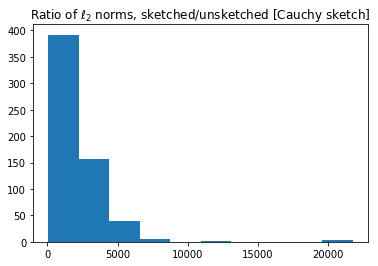

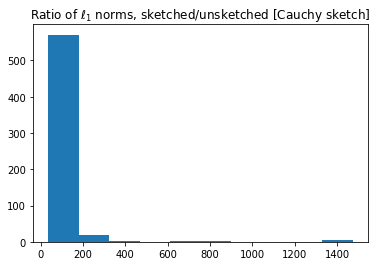

In [29]:
S   = rng.standard_cauchy((m,M))/np.sqrt(m)

SX  = S@X

col2Norms_sk = scipy.linalg.norm( SX, ord=2, axis=0)
col1Norms_sk = scipy.linalg.norm( SX, ord=1, axis=0)

plt.hist( col2Norms_sk / col2Norms )
plt.title('Ratio of $\ell_2$ norms, sketched/unsketched [Cauchy sketch]')
plt.show()

plt.hist( col1Norms_sk / col1Norms )
plt.title('Ratio of $\ell_1$ norms, sketched/unsketched [Cauchy sketch]')
plt.show()

Not as effective as Gaussian sketches at preserving $\ell_2$ distance, but better than a Gaussian sketch at preserving $\ell_1$ distances.

## Solve $\ell_p$ regression via sketching

So we'll try a Cauchy sketch.  Our first attempt is a "sketch-to-solve" approach,
$$\min_x \| SA - Sb \|_1. $$

Let's see how that does.  First, we'll make some problem data $A,b$ and solve the original problem via `cvxpy` to get a reference solution.

In [32]:
import cvxpy as cvx
M, N = int(1e3), int(1e2)

A   = rng.standard_normal( (M,N) )@np.diag(np.logspace(0,4,N))@(
    rng.standard_normal((N,N) ) + 0.03*np.eye(N) )
Z   = scipy.sparse.random(M, N, density=0.01)
A   = np.hstack( (A,Z.toarray() ) )
M, N = A.shape

x0  = rng.standard_normal( (N,1) )
b   = A@x0 + .01*rng.standard_normal((M,1))

# cvxpy code:
x     = cvx.Variable(N)
obj   = cvx.Minimize(cvx.norm(A*x-b.ravel() , 1 ))
prob  = cvx.Problem(obj)
prob.solve(verbose=True)
x_l1  = x.value


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.641e-10  +1.688e-09  +2e+05  7e-04  3e-05  1e+00  1e+02    ---    ---    1  1  - |  -  - 
 1  -3.396e-03  +7.439e-03  +2e+03  7e-06  3e-07  2e-02  1e+00  0.9890  1e-04   1  2  2 |  0  0
 2  +6.076e-02  +6.113e-02  +6e+01  2e-07  7e-09  6e-04  3e-02  0.9768  1e-04   2  3  3 |  0  0
 3  +2.192e+00  +2.193e+00  +9e+00  3e-08  1e-09  1e-03  5e-03  0.8814  4e-02   2  2  2 |  0  0
 4  +5.114e+00  +5.115e+00  +2e+00  6e-09  1e-09  4e-04  1e-03  0.8229  4e-02   2  2  2 |  0  0
 5  +5.959e+00  +5.959e+00  +6e-01  2e-09  2e-09  1e-04  3e-04  0.7794  4e-02   3  2  2 |  0  0
 6  +6.220e+00  +6.220e+00  +2e-01  1e-09  1e-09  8e-05  9e-05  0.8031  2e-01   3  3  3 |  0  0
 7  +6.314e+00  +6.314e+00  +8e-02  6e-10  9e-10  4e-05  4e-05  0.8286  3e-01   3  2  2 |  0  0
 8  +6.357e+00  +6.357e+00  +3e-02  4e-10  5e-

Now let's solve the sketched problem:

In [33]:
# Sketch the data
m     = 2*N
S     = rng.standard_cauchy((m,M))/np.sqrt(m)
SA    = S@A
Sb    = S@b

# Solve the sketched problem
x     = cvx.Variable(N)
obj   = cvx.Minimize(cvx.norm(SA*x-Sb.ravel() , 1 ))
prob  = cvx.Problem(obj)
prob.solve(verbose=True)
x_sk  = x.value

objFcn= lambda x : scipy.linalg.norm( A@x - b.ravel(), 1 )

objTrue = objFcn( x_l1 )
objSk   = objFcn( x_sk )
err     = scipy.linalg.norm( x_l1 - x_sk )
print(f'True objective value is {objTrue}, objective via sketching is {objSk}')
print(f'Distance ||x-x_sk|| is {err}')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  +3.994e-06  +6e+05  3e-05  4e-06  1e+00  8e+02    ---    ---    1  2  - |  -  - 
 1  +7.297e+01  +7.305e+01  +1e+04  4e-07  7e-08  9e-02  1e+01  0.9841  1e-04   2  2  3 |  0  0
 2  +2.466e+01  +2.471e+01  +1e+03  5e-08  1e-08  5e-02  2e+00  0.8801  4e-03   2  3  3 |  0  0
 3  +7.337e+01  +7.346e+01  +4e+02  2e-08  4e-09  8e-02  5e-01  0.7497  6e-02   2  2  3 |  0  0
 4  +9.693e+01  +9.697e+01  +1e+02  5e-09  1e-09  4e-02  1e-01  0.7215  4e-02   3  3  3 |  0  0
 5  +1.048e+02  +1.048e+02  +4e+01  2e-09  4e-10  2e-02  5e-02  0.7322  1e-01   3  3  3 |  0  0
 6  +1.081e+02  +1.081e+02  +2e+01  7e-10  2e-10  1e-02  2e-02  0.6881  1e-01   3  4  3 |  0  0
 7  +1.096e+02  +1.096e+02  +6e+00  3e-10  7e-11  5e-03  8e-03  0.6550  7e-02   4  4  4 |  0  0
 8  +1.104e+02  +1.104e+02  +2e+00  8e-11  3e-

#### Solve the other way: use "leverage score" sampling
(Not really usual leverage scores)

The direct sketch-to-solve didn't work that well.  Another approach is to take the sketched matrix $SA$ and compute a $QR$ factorization; then $$U=AR^{-1}$$ (which can also be approximated; see section 3.4 in Woodruff's monograph) is a **well-conditioned basis** and we can do "leverage score"-like sampling with each row selected proportional to the $\ell_1$ norms of the rows of $U$.

In [44]:
m     = 2*N
S     = rng.standard_cauchy((m,M))/np.sqrt(m)
SA    = S@A
Sb    = S@b

R           = np.linalg.qr(SA,mode='r')
# set basis = A*R^{-1}, or basis^T = R^{-T}A^T
basis       = scipy.linalg.solve_triangular(R, A.T, trans='T').T
levScores   = scipy.linalg.norm( basis, ord=1, axis=1)
ind         = rng.choice( M, size=m, replace=True, p=levScores/levScores.sum() )

... and now sub-sample according to these "leverage scores":

In [45]:
SA    = A[ind,:]
Sb    = b[ind]

x     = cvx.Variable(N)
obj   = cvx.Minimize(cvx.norm(SA*x-Sb.ravel() , 1 ))
prob  = cvx.Problem(obj)
prob.solve(verbose=True)
x_sk  = x.value

objFcn= lambda x : scipy.linalg.norm( A@x - b.ravel(), 1 )

objTrue = objFcn( x_l1 )
objSk   = objFcn( x_sk )
err     = scipy.linalg.norm( x_l1 - x_sk )
print(f'True objective value is {objTrue}, objective via sketching is {objSk}')
print(f'Distance ||x-x_sk|| is {err}')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.940e-10  +5.173e-09  +9e+04  7e-04  2e-05  1e+00  1e+02    ---    ---    1  2  - |  -  - 
 1  +2.620e-03  +1.399e-02  +1e+03  8e-06  3e-07  2e-02  1e+00  0.9890  1e-04   1  1  2 |  0  0
 2  +1.024e-02  +1.057e-02  +2e+01  1e-07  5e-09  5e-04  2e-02  0.9819  1e-04   2  2  2 |  0  0
 3  +4.516e-01  +4.522e-01  +3e+00  2e-08  7e-10  6e-04  4e-03  0.8706  3e-02   2  2  2 |  0  0
 4  +1.029e+00  +1.030e+00  +7e-01  5e-09  1e-09  2e-04  8e-04  0.8168  4e-02   2  3  2 |  0  0
 5  +1.143e+00  +1.143e+00  +3e-01  2e-09  2e-09  2e-04  3e-04  0.7424  2e-01   2  3  3 |  0  0
 6  +1.197e+00  +1.197e+00  +1e-01  1e-09  1e-09  9e-05  1e-04  0.6992  1e-01   3  3  3 |  0  0
 7  +1.215e+00  +1.215e+00  +6e-02  7e-10  9e-10  7e-05  8e-05  0.6943  4e-01   3  3  3 |  0  0
 8  +1.231e+00  +1.231e+00  +3e-02  5e-10  6e-

The results aren't that great still.  My general experience is that sketching doesn't work well in practice for any kind of norm-based problem if the norm is not the Euclidean norm.  Theoretically there can be benefits, but you'd need to have very high-dimensional data to see the benefit.